In [1]:
import numpy as np
import torch

import sys
sys.path.append("../")

from src.models.RVGAE import RVGAE
from src.datasets.utils import normalize_adjacency, remove_self_loops
from src.plot import plot_dynamic_graph

In [2]:
data_path = "../data/data.npz"
num_samples = 20

hidden_dim = 32
latent_dim = 16 

batch_size = 5
num_epochs = 100
learning_rate = 1e-3

In [3]:
data_dic = dict(np.load(data_path, allow_pickle=True).items())
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data_dic["X"]).float(), torch.from_numpy(data_dic["A"]).float())
node_dim = dataset.tensors[0].shape[-1]
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = RVGAE(node_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
elbo_results = []
nll_results = []
kl_results = []

model.train()

for epoch in range(num_epochs):

    epoch_elbo = 0
    epoch_nll = 0
    epoch_kl = 0

    for X, A in dataloader:

        A_norm = normalize_adjacency(A)
        A_norm = remove_self_loops(A_norm)

        optimizer.zero_grad()
        A_recon, Z_posterior, Z_prior = model.forward(X, A_norm)
        elbo, nll, kl = model.loss(A_recon, A, Z_posterior, Z_prior)
        elbo.backward()
        optimizer.step()

        epoch_elbo += elbo.item() / len(dataloader)
        epoch_nll += nll / len(dataloader)
        epoch_kl += kl / len(dataloader)

    elbo_results += [epoch_elbo]
    nll_results += [epoch_nll]
    kl_results += [epoch_kl]

    if epoch % 10 == 0:
        print("epoch {:4d} | elbo {:6.4f} | nll {:6.4f} | kl {:6.4f}".format(epoch, elbo_results[-1], nll_results[-1], kl_results[-1]))

epoch    0 | elbo 1.1347 | nll 1.1234 | kl 0.0113
epoch   10 | elbo 1.1345 | nll 1.1234 | kl 0.0111
epoch   20 | elbo 1.1344 | nll 1.1234 | kl 0.0111
epoch   30 | elbo 1.1343 | nll 1.1234 | kl 0.0109
epoch   40 | elbo 1.1341 | nll 1.1234 | kl 0.0108
epoch   50 | elbo 1.1339 | nll 1.1232 | kl 0.0107
epoch   60 | elbo 1.1339 | nll 1.1233 | kl 0.0106
epoch   70 | elbo 1.1336 | nll 1.1231 | kl 0.0105
epoch   80 | elbo 1.1336 | nll 1.1231 | kl 0.0105
epoch   90 | elbo 1.1334 | nll 1.1230 | kl 0.0104


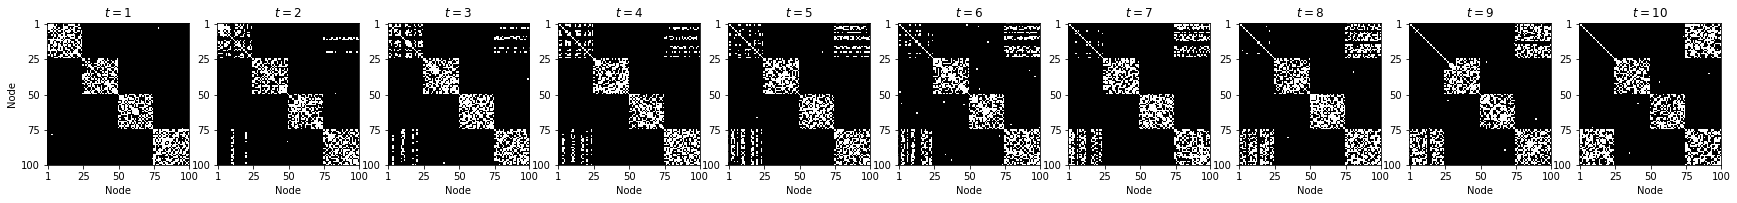

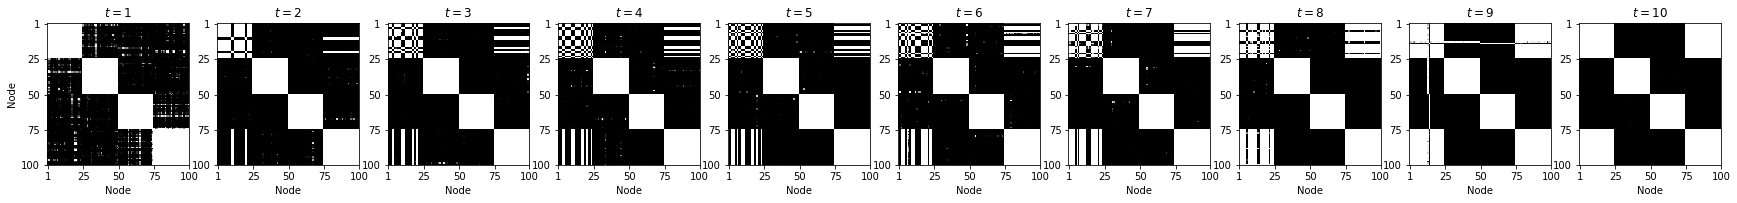

In [9]:
plot_dynamic_graph(A[0].detach().numpy())
plot_dynamic_graph(A_recon[0].detach().sigmoid().numpy())